# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 1 - Atomistic simulations with [pyiron](https://pyiron.org)**


### **Exercise 2: Creating and working with structure databases**

Before the excercise, you should:

* Finish exercise 1

The aim of this exercise is to make you familiar with:

* Creating structure databases and working with them for potential fitting (day 2)

## **Importing necessary modules and creating a project**

This is done the same way as shown in the first exercise

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

In [2]:
from pyiron import Project

In [3]:
pr = Project("creating_datasets")

## Creating a structure "container" from the data

We now go over the jobs generated in the first notebook to store structures, energies, and forces into a structure container which will later be used for potential fitting

**Note**: Usually these datasets are created using highly accurate DFT calculations. But for practical reasons, we only demonstrate how to do this using data from LAMMPS calculations (the workflow remain the same)

In [4]:
# Access the project created in exercise 1 
pr_fs = pr["../first_steps"]

In [5]:
# Create a TrainingContainer job (to store structures and databases)
container = pr.create.job.TrainingContainer('dataset_example')

## **Add structures from the E-V curves**

For starters, we append structures from the energy volume curves we calculated earlier

In [6]:
# Iterate over the jobs in this sub-project and append the final structure, potential energy, and forces
for job in pr_fs["E_V_curve"].iter_jobs(status="finished"):
    container.include_job(job, iteration_step=-1)

  0%|          | 0/7 [00:00<?, ?it/s]

We can obtain this data as a `pandas` table

In [7]:
container.to_pandas()

,name,atoms,energy,forces,stress,number_of_atoms
0,job_a_3_8,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.191547,"[[7.762927051164611e-17, -5.834472503940611e-17, 5.834472503940611e-17]]","[22.676444426662105, 22.67644442583243, 22.67644442268594, 1.1860975064337254e-10, -5.400215741246939e-11, 5.4005067795515064e-11]",1
1,job_a_3_9,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.306273,"[[3.9688564710863087e-17, 4.4947377290194504e-17, 3.355724564399421e-17]]","[11.119873370002683, 11.119873370145102, 11.119873369482312, -6.828056939411908e-10, -3.97049734601751e-10, 3.9704682421870533e-10]",1
2,job_a_4_0,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.355322,"[[-2.2398470094651915e-17, -3.0247206656949597e-18, 2.2650876399242214e-17]]","[2.8532790573942868, 2.853279056435899, 2.8532790564358965, -1.03412658063462e-09, 1.1582415027078241e-09, 7.366397767327727e-10]",1
3,job_a_4_1,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.353423,"[[2.1964558398106292e-17, -1.0183088924702441e-17, 2.9809244658249695e-17]]","[-2.946765654316672, -2.9467656552939925, -2.9467656552939894, -5.758001861977391e-10, 1.4562829164788129e-12, 5.7911965996027e-10]",1
4,job_a_4_2,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.312514,"[[-5.740214732386056e-17, -4.040539787997903e-17, 4.040539787997903e-17]]","[-6.906298594642338, -6.906298594356355, -6.906298596841324, -2.88610317511484e-10, -4.773595719598234e-10, 4.773595719598234e-10]",1
5,job_a_4_3,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.242240,"[[2.655563258192633e-17, 1.9677038931290205e-17, -5.892935039838457e-17]]","[-9.500715479394913, -9.500715480623736, -9.500715480623732, -3.422537702135742e-11, 3.2583084248472004e-10, 4.391295078676194e-11]",1
6,job_a_4_4,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.150354,"[[-1.439476084367466e-17, -8.764057119853195e-17, 9.135948264343227e-18]]","[-11.090415187614997, -11.090415187842105, -11.09041518803039, -9.905415936373175e-11, 3.695022314786911e-11, -3.6953133530914785e-11]",1


## **Add structures from the MD**

We also add some structures obtained from the MD simulations

In [8]:
# Reloading the MD job
job_md = pr_fs["lammps_job"]

In [9]:
# Iterate over the MD-trajectory to append structures

traj_length = len(job_md["output/generic/positions"])
stride = 10 # append structures every 10 steps

for i in range(0, traj_length, stride):
    container.include_job(job_md, iteration_step=i)

## **Add some defect structures (vacancies, surfaces, etc)**

It's necessary to also include some defect structures, and surfaces to the training dataset

In [10]:
# Setup a MD calculation for a structure with a vacancy
job_lammps = pr.create.job.Lammps("lammps_job_vac")
job_lammps.structure = pr.create.structure.bulk("Al", cubic=True, a=3.61).repeat([3, 3, 3])
del job_lammps.structure[0]
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)
job_lammps.run()

The job lammps_job_vac was saved and received the ID: 17073786


In [11]:
# Setup a MD calculation for a surface structure
job_lammps = pr.create.job.Lammps("lammps_job_surf")
job_lammps.structure = pr.create.structure.surface("Al", surface_type="fcc111", size=(4, 4, 8), vacuum=12, orthogonal=True)
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)
job_lammps.run()

The job lammps_job_surf was saved and received the ID: 17073787


In [12]:
pr

{'groups': [], 'nodes': ['lammps_job_vac', 'lammps_job_surf']}

We now add these structures to the dataset

In [13]:
for job_md in pr.iter_jobs(status="finished", hamilton="Lammps"):
    pos = job_md["output/generic/positions"]
    stride = 10
    for i in range(0, job.number_of_structures, stride):
        container.include_job(job_md, iteration_step=i)

  0%|          | 0/2 [00:00<?, ?it/s]

We run the job sto store this dataset in the pyiron database

In [14]:
container.run()

The job dataset_example was saved and received the ID: 17073788


In [15]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,17073786,finished,Al107,lammps_job_vac,/lammps_job_vac,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/creating_datasets/,2022-05-12 15:00:53.950303,2022-05-12 15:00:58.228251,4.0,zora@cmti001#1,Lammps,0.1,None,None
1,17073787,finished,Al128,lammps_job_surf,/lammps_job_surf,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/creating_datasets/,2022-05-12 15:00:59.263900,2022-05-12 15:01:03.659497,4.0,zora@cmti001#1,Lammps,0.1,None,None
2,17073788,finished,None,dataset_example,/dataset_example,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/creating_datasets/,2022-05-12 15:01:05.587884,NaT,NaN,zora@cmti001#1,TrainingContainer,0.4,None,None


## **Reloading the dataset**

This dataset can ow be reloaded anywhere to use in the potential fitting procedures

In [16]:
dataset = pr["dataset_example"]
dataset.to_pandas()

,name,atoms,energy,forces,stress,number_of_atoms
0,job_a_3_8,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.191547,"[[7.762927051164611e-17, -5.834472503940611e-17, 5.834472503940611e-17]]","[22.676444426662105, 22.67644442583243, 22.67644442268594, 1.1860975064337254e-10, -5.400215741246939e-11, 5.4005067795515064e-11]",1
1,job_a_3_9,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.306273,"[[3.9688564710863087e-17, 4.4947377290194504e-17, 3.355724564399421e-17]]","[11.119873370002683, 11.119873370145102, 11.119873369482312, -6.828056939411908e-10, -3.97049734601751e-10, 3.9704682421870533e-10]",1
2,job_a_4_0,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.355322,"[[-2.2398470094651915e-17, -3.0247206656949597e-18, 2.2650876399242214e-17]]","[2.8532790573942868, 2.853279056435899, 2.8532790564358965, -1.03412658063462e-09, 1.1582415027078241e-09, 7.366397767327727e-10]",1
3,job_a_4_1,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.353423,"[[2.1964558398106292e-17, -1.0183088924702441e-17, 2.9809244658249695e-17]]","[-2.946765654316672, -2.9467656552939925, -2.9467656552939894, -5.758001861977391e-10, 1.4562829164788129e-12, 5.7911965996027e-10]",1
4,job_a_4_2,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.312514,"[[-5.740214732386056e-17, -4.040539787997903e-17, 4.040539787997903e-17]]","[-6.906298594642338, -6.906298594356355, -6.906298596841324, -2.88610317511484e-10, -4.773595719598234e-10, 4.773595719598234e-10]",1
5,job_a_4_3,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.242240,"[[2.655563258192633e-17, 1.9677038931290205e-17, -5.892935039838457e-17]]","[-9.500715479394913, -9.500715480623736, -9.500715480623732, -3.422537702135742e-11, 3.2583084248472004e-10, 4.391295078676194e-11]",1
6,job_a_4_4,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-3.150354,"[[-1.439476084367466e-17, -8.764057119853195e-17, 9.135948264343227e-18]]","[-11.090415187614997, -11.090415187842105, -11.09041518803039, -9.905415936373175e-11, 3.695022314786911e-11, -3.6953133530914785e-11]",1
7,lammps_job,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-362.874711,"[[6.579806144380031e-15, 3.8510861166685137e-16, 7.936359902593893e-16], [7.41334077458689e-15, -2.03396327558281e-15, -2.4650420593630397e-15], [1.1934897514720401e-15, 3.5214886562329204e-16, -3...","[1.66505777613937, 1.65597478683186, 1.4904530051861802, -0.017955018197828302, 0.0636336051961352, -0.0425636166039662]",108
8,lammps_job,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-350.909167,"[[-0.239499213089358, 0.43002220782184, -0.708103445257233], [-0.0263833123646737, -0.311437125473446, -0.16312813349440602], [0.428287812967704, 0.657964172831875, 0.12955966427394305], [0.632399...","[0.468704941797838, 0.225251352652467, 0.759106586375767, -0.16931990268975503, 0.150086581331058, -0.313317995397465]",108
9,lammps_job,"[element: [None, AtomicNumber 13\nAtomicRadius 118.0\nAtomicMass 26.981539\nColor Silver\nCovalentRadius ...",-350.123272,"[[0.190046360301228, 0.417440626778757, 0.20258207002451503], [0.497102024530882, 0.01764295316103203, -0.29107865400839894], [-0.336089257956967, 0.839410750905879, 0.25473178060898904], [0.13549...","[0.065220204962367, 0.25614026410411306, -0.139548026512665, 0.0388065639699095, -0.0898526256555141, 0.0371029380265526]",108


We can now inspect the data in this dataset quite easily

In [17]:
struct = dataset.get_structure(10)

In [18]:
struct.plot3d()

NGLWidget()

,V,E
0,13.718000,-3.191547
1,14.829750,-3.306273
2,16.000000,-3.355322
3,17.230250,-3.353423
4,18.522000,-3.312514
5,19.876750,-3.242240
6,21.296000,-3.150354
7,16.484816,-3.359951
8,17.297089,-3.249159
9,17.428075,-3.241882


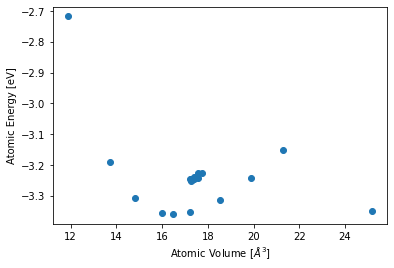

In [19]:
dataset.plot.energy_volume()

In [20]:
structures, energies, forces, num_atoms  = dataset.to_list()

In [21]:
df = dataset.to_pandas()

Text(0.5, 0, 'Force Components [eV/$\\mathrm{\\AA}]$')

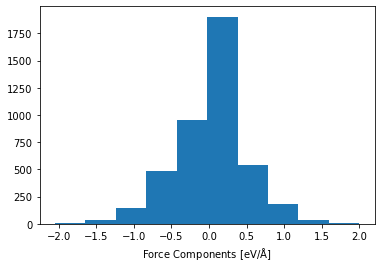

In [22]:
plt.hist(np.concatenate(df.forces).flatten())
plt.xlabel('Force Components [eV/$\mathrm{\AA}]$')

The datasets used in the potential fitting procedure for day 2 (obtained from accurate DFT calculations) will be accessed in the same way